In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

Custom dataset class to label T-shirts (class 0) as normal, other classes as abnormal

In [2]:
class FashionMNISTCustom(Dataset):
    def __init__(self, root='./data', train=True, transform=None, normal_class=0):
        """
            Custom FashionMNIST dataset with normal and abnormal labels.
            Normal class will be labeled as 0, all other classes as 1.
        """
        self.dataset = datasets.FashionMNIST(root=root, train=train, download=True)
        self.normal_class = normal_class  # Set the normal class (e.g., T-shirts)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        # Label normal (T-shirt) as 0, abnormal (other) as 1
        label = 0 if label == self.normal_class else 1
        if self.transform:
            img = self.transform(img)
        return img, label

SSAE Model Definition

In [3]:
class SSAE(nn.Module):
    def __init__(self):
        super(SSAE, self).__init__()
        # Encoder network: compresses image to 64 dimensions
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),  # Input layer (28*28 image size)
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        # Decoder network: reconstructs the image from 64 dimensions
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()  # Sigmoid to ensure pixel values are between 0 and 1
        )

    def forward(self, x):
        # Forward pass through encoder and decoder
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def semi_supervised_loss(self, inputs, outputs, labels, margin=0.2):
        # Standard reconstruction loss (Mean Squared Error)
        reconstruction_loss = F.mse_loss(outputs, inputs, reduction='none').mean(dim=1)

        # Separate normal and abnormal samples
        abnormal = labels > 0  # True for abnormal samples

        # Calculate additional abnormal loss
        abnormal_loss = reconstruction_loss[abnormal].mean() if abnormal.any() else torch.tensor(0.0)

        # Combine normal reconstruction loss and abnormal loss
        return reconstruction_loss.mean() + abnormal_loss

Data preparation

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = FashionMNISTCustom(train=True, transform=transform, normal_class=0)  # T-shirts as normal
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

View samples from the dataset with labels (Normal: 0, Abnormal: 1)

In [5]:
def show_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        img, label = dataset[i]  # Get image and label
        
        # Convert tensor to numpy array for displaying
        if isinstance(img, torch.Tensor):
            img = img.numpy().squeeze()  # Convert to numpy and squeeze to remove extra dimensions
        
        axes[i].imshow(img, cmap='gray')  # Display the image
        axes[i].set_title(f"Label: {'Normal' if label == 0 else 'Abnormal'}")
        axes[i].axis('off')
    
    plt.show()

Total number of samples in the dataset: 60000


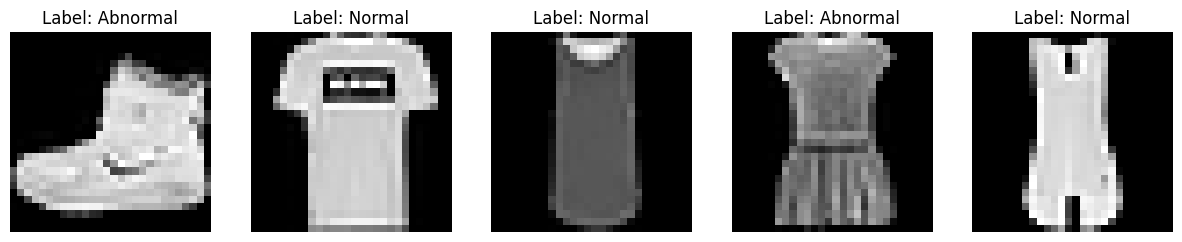

In [6]:
# Dataset with T-shirts (class 0) as normal and others as abnormal
train_dataset = FashionMNISTCustom(train=True, transform=transforms.ToTensor(), normal_class=0)

# Check the length of the dataset
print(f"Total number of samples in the dataset: {len(train_dataset)}")

# Show a few samples with their labels
show_samples(train_dataset, num_samples=5)

In [7]:
model = SSAE()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [8]:
model

SSAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

Training loop

In [9]:
# List to store loss values for plotting
loss_values = []

for epoch in range(10):
    total_loss = 0
    
    # Use tqdm for a nice progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/10 (SSAE)")
    
    for images, labels in progress_bar:
        # Flatten the images for the autoencoder
        images = images.view(-1, 28*28)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss = model.semi_supervised_loss(images, outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Update tqdm progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())
    
    # Calculate the average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)
    
    # Print the average loss for the current epoch
    print(f"Epoch [{epoch+1}/10], Avg Loss: {avg_loss:.4f}")
    
    # Save the model after each epoch
    torch.save(model.state_dict(), f'ssae_models/ssae_fashion_mnist_epoch_{epoch+1}.pth')

Epoch 1/10 (SSAE):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/10 (SSAE): 100%|██████████| 938/938 [00:34<00:00, 27.49it/s, loss=0.066] 


Epoch [1/10], Avg Loss: 0.1176


Epoch 2/10 (SSAE): 100%|██████████| 938/938 [00:35<00:00, 26.58it/s, loss=0.055] 


Epoch [2/10], Avg Loss: 0.0571


Epoch 3/10 (SSAE): 100%|██████████| 938/938 [00:28<00:00, 33.23it/s, loss=0.0559]


Epoch [3/10], Avg Loss: 0.0483


Epoch 4/10 (SSAE): 100%|██████████| 938/938 [00:30<00:00, 30.93it/s, loss=0.043] 


Epoch [4/10], Avg Loss: 0.0450


Epoch 5/10 (SSAE): 100%|██████████| 938/938 [00:32<00:00, 29.10it/s, loss=0.0413]


Epoch [5/10], Avg Loss: 0.0426


Epoch 6/10 (SSAE): 100%|██████████| 938/938 [00:32<00:00, 28.82it/s, loss=0.041] 


Epoch [6/10], Avg Loss: 0.0405


Epoch 7/10 (SSAE): 100%|██████████| 938/938 [00:48<00:00, 19.45it/s, loss=0.039] 


Epoch [7/10], Avg Loss: 0.0387


Epoch 8/10 (SSAE): 100%|██████████| 938/938 [00:46<00:00, 20.03it/s, loss=0.0385]


Epoch [8/10], Avg Loss: 0.0372


Epoch 9/10 (SSAE): 100%|██████████| 938/938 [00:47<00:00, 19.89it/s, loss=0.0394]


Epoch [9/10], Avg Loss: 0.0360


Epoch 10/10 (SSAE): 100%|██████████| 938/938 [00:49<00:00, 19.14it/s, loss=0.0392]


Epoch [10/10], Avg Loss: 0.0350


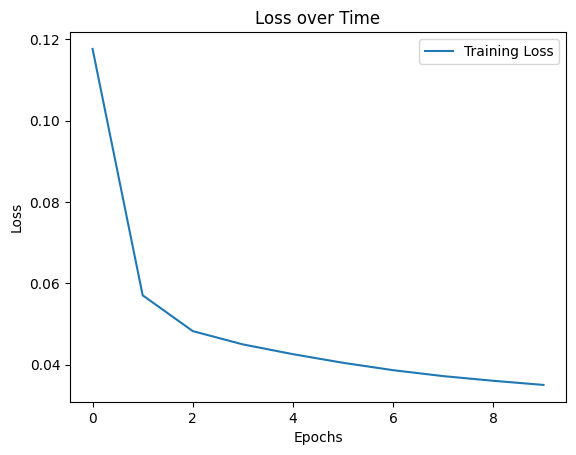

In [10]:
plt.plot(loss_values, label="Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Time')
plt.legend()
plt.show()

Checking Model's Performance and Visualizing Reconstruction

In [11]:
def visualize_reconstruction(model, dataset, num_samples=5):
    # model.eval()  # Set the model to evaluation mode
    model.load_state_dict(torch.load('ssae_models/ssae_fashion_mnist_epoch_10.pth'))
    model.eval()
    fig, axes = plt.subplots(2, num_samples, figsize=(12, 4))
    
    for i in range(num_samples):
        # Get a sample from the dataset
        img, label = dataset[i]
        img = img.view(1, -1)  # Flatten image
        
        # Forward pass to get the reconstruction
        with torch.no_grad():
            reconstructed_img = model(img)
        
        # Reshape images back to 28x28 for visualization
        img = img.view(28, 28)
        reconstructed_img = reconstructed_img.view(28, 28)
        
        # Plot original image
        axes[0, i].imshow(img.numpy(), cmap='gray')
        axes[0, i].set_title(f"Original: {'Normal' if label == 0 else 'Abnormal'}")
        axes[0, i].axis('off')
        
        # Plot reconstructed image
        axes[1, i].imshow(reconstructed_img.numpy(), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    
    plt.show()

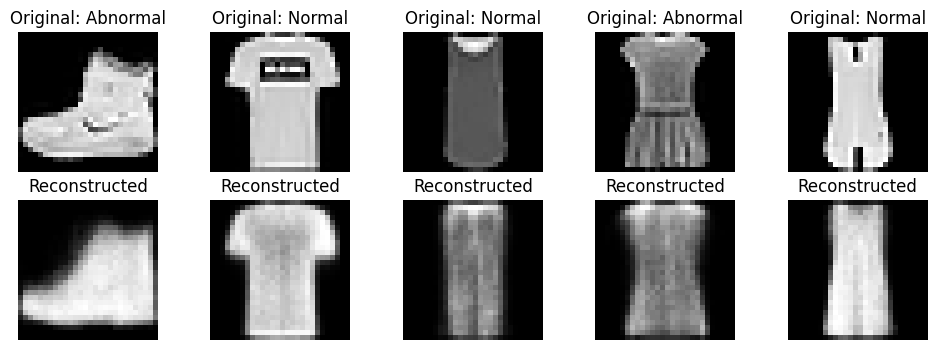

In [12]:
visualize_reconstruction(model, train_dataset)